## Import necessary modules
Dependencies:
 - numpy
 - pandas
 - matplotlib

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
sys.path.append("../src/")
from lbd_functions import plot_elevation,plot3sections,plot3Dreal,printtimelogwithstarline,printtimelog
from lbd_functions import gen_concatenated_lenses_params,gen_facies_youth_mx,get_facies_prop
from lbd_functions import Lense, get_model_dh_litho_thickness, get_model_litho_thickness,plot_clay_and_sand_ecdfs_err
from utils import check_plot_2_sections, get_ecdf, interp_ecdf_normalize_x, interpolate_ecdf, get_ecdf_area_difference
from scipy.interpolate import RegularGridInterpolator

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import matplotlib.pyplot as plt

from pyevtk.hl import gridToVTK

top_basement_fn = '../data/interfaces-sediment-basement/bot_base.npy'
top_weathered_basement_fn = '../data/interfaces-sediment-basement/bot_delt.npy'
top_deltaic_sediments_fn = '../data/interfaces-sediment-basement/top_delt.npy'

# bh_summary_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_summary.csv'
# ref_err_fn = '../data/boreholes-processed/LBW_extended_error-tolerance.pickle'
bh_summary_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_corrected_summary.csv'
ref_err_fn = '../data/boreholes-processed/LBW_extended_corrected_error-tolerance.pickle'

output_fd = '../data/models-age-facies/'
fig_fd = '../figures/'

plot=True
Verb=True

## Parameters
Loading model parameters by running the parameter file

In [2]:
# DEFINE RANGE FOR PARAMETERS TO EXPLORE from step 1 optim
intensity_sand = 0.1307465954441502 #0.1357085524950305
intensity_clay = 0.08383357036104656 #0.10254000999344669

truncation_sand = 0.3 # 0.2
truncation_clay = 0.18278345528849027 # 0.2
thickness_sand = 4.9647519632349475 # 4.0
thickness_clay = 2.78029186323164 # 3.0
length_sand = 3925.734809544285 # 6000.0
length_clay = 4291.719464446728 # 6000.0

nseeds = 100

stats_fn = 'stats_05a_'+str(nseeds)+'_calib_reals_corrected.csv'

# seed_increment = 0 # 0,1 and 2
# filename_suffix = "_real_"+str(seed_increment)

# print(filename_suffix)

In [3]:
# DEFINE FIXED PARAMETERS
intensity_tol = 5.0/100
truncation_tol = 7.5/100
length_tol = 50/100
thickness_tol = 40/100
truncationdist = 'uniform'
lengthdist = 'uniform'
thicknessdist = 'uniform'
anisotropy = 4
anisotropy_tol = 2
anisotropydist = 'uniform'
dipdir = 90*np.pi/180 # in radians
dipdir_tol = 10*np.pi/180 # in radians
dipdirdist = 'normal'
dip = 0
dip_tol = 0
dipdist = 'normal'
facies_sand = 2
facies_clay = 3

printtimelogwithstarline('DEFINE PARAMETERS')
lbdseed = 12345

printtimelog('model boundaries')
xmin=5.30E5
xmax=5.45E5
ymin=7.830E6
ymax=7.842E6
zmin=-80
zmax=20
dx=dy=250
dz=1

lithocodes = [-1,0,1,2,3]
labels = ["basement","weathered-basement","intermediate","coarse-grained","fine-grained"]
lithocolors = ["pink","lavenderblush", "sienna", "gold", "grey"]
ndhsamples = 500 # to estimate thicknesses from generated models
rng = np.random.default_rng(lbdseed) # +seed_increment

**********************************************************************
24-Feb-2025 (20:02:49) - DEFINE PARAMETERS
**********************************************************************
24-Feb-2025 (20:02:49) - model boundaries


In [4]:
intensity_sand_tol = intensity_tol * intensity_sand
intensity_clay_tol = intensity_tol * intensity_clay
length_sand_tol = length_tol * length_sand
length_clay_tol = length_tol * length_clay
thickness_sand_tol = thickness_tol *thickness_sand 
thickness_clay_tol = thickness_tol *thickness_clay 
# DEFINE LENSES CLASSES
sandLenses = Lense(intensity_sand,intensity_sand_tol,
                 truncation_sand,truncation_tol,truncationdist,
                 length_sand,length_sand_tol,lengthdist,
                 thickness_sand,thickness_sand_tol,thicknessdist,
                 anisotropy,anisotropy_tol,anisotropydist,
                 dipdir,dipdir_tol,dipdirdist,
                 dip,dip_tol,dipdist,facies_sand)
clayLenses = Lense(intensity_clay,intensity_clay_tol,
                 truncation_clay,truncation_tol,truncationdist,
                 length_clay,length_clay_tol,lengthdist,
                 thickness_clay,thickness_clay_tol,thicknessdist,
                 anisotropy,anisotropy_tol,anisotropydist,
                 dipdir,dipdir_tol,dipdirdist,
                 dip,dip_tol,dipdist,facies_clay)


## Processing input data

In [5]:

# PROCESSING INPUT DATA
# AREA OF INTEREST GRID
aoi_nx = int((xmax-xmin)/dx)
aoi_ny = int((ymax-ymin)/dy)
aoi_nz = int((zmax-zmin)/dz)
aoi_vx = np.linspace(xmin+dx/2,xmax-dx/2,aoi_nx,endpoint=True)
aoi_vy = np.linspace(ymin+dy/2,ymax-dy/2,aoi_ny,endpoint=True)
aoi_vz = np.linspace(zmin+dz/2,zmax-dz/2,aoi_nz,endpoint=True)
aoi_xx,aoi_yy = np.meshgrid(aoi_vx,aoi_vy,indexing='xy')
aoi_pts = np.array([aoi_xx.flatten(),aoi_yy.flatten()]).T
# LOAD INTERFACES
top_basement =  np.load(top_basement_fn)
top_weathered_basement =  np.load(top_weathered_basement_fn)
top_deltaic_sediments =  np.load(top_deltaic_sediments_fn)
# GET INTERFACES DIMENSIONS
top_nx = len(np.unique(top_basement[:,0]))
top_ny = len(np.unique(top_basement[:,1]))
# GET INTERFACES X & Y COORDINATES
top_xx = np.flipud(np.reshape(top_basement[:,0],(top_ny,top_nx)))
top_yy = np.flipud(np.reshape(top_basement[:,1],(top_ny,top_nx)))
# RESHAPE INTERFACES AS 2D ARRAYS
zz_top_basement = np.flipud(np.reshape(top_basement[:,-1],(top_ny,top_nx)))
zz_top_weathered_basement = np.flipud(np.reshape(top_weathered_basement[:,-1],(top_ny,top_nx)))
zz_top_deltaic_sediments = np.flipud(np.reshape(top_deltaic_sediments[:,-1],(top_ny,top_nx)))
# ESTIMATE INTERFACES MASK
mask = zz_top_basement< zz_top_basement.max()
# APPLY MASK TO REMOVE MAX PLATEAU VALUES
zz_top_basement[mask==False]=np.nan
zz_top_weathered_basement[mask==False]=np.nan
zz_top_deltaic_sediments[mask==False]=np.nan
# ESTIMATE RESOLUTION
xc_min = top_basement[:,0].min()
xc_max = top_basement[:,0].max()
top_dx = (xc_max-xc_min)/(top_nx-1)
yc_min = top_basement[:,1].min()
yc_max = top_basement[:,1].max()
top_dy = (yc_max-yc_min)/(top_ny-1)
# INDEX OF INTERFACES IMAGES TO SELECT TO BUILD INTERPOLATOR
ix_select = (np.where(
    (top_xx >= xmin-top_dx) & (top_xx <= xmax+top_dx) &
    (top_yy >= ymin-top_dy) & (top_yy <= ymax+top_dy)
))
top_vx = np.sort(np.unique(top_xx[ix_select]))
top_vy = np.sort(np.unique(top_yy[ix_select]))
    
ori_top_basement = np.reshape(zz_top_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_weathered_basement = np.reshape(zz_top_weathered_basement[ix_select],(len(top_vy),len(top_vx)))
ori_top_deltaic_sediments = np.reshape(zz_top_deltaic_sediments[ix_select],(len(top_vy),len(top_vx)))

# DEFINE INTERPOLATORS
# # flip on y axis because of increasing vy
# data_tbt = np.flipud(ori_top_basement)
# data_twb = np.flipud(ori_top_weathered_basement)
# data_tds = np.flipud(ori_top_deltaic_sediments)

interp_top_basement = RegularGridInterpolator((top_vy, top_vx),ori_top_basement)
interp_top_weathered_basement = RegularGridInterpolator((top_vy, top_vx), ori_top_weathered_basement)
interp_top_deltaic_sediments = RegularGridInterpolator((top_vy, top_vx), ori_top_deltaic_sediments)

# INTERPOLATE INTERFACES
aoi_pts = np.array([aoi_yy.flatten(),aoi_xx.flatten()]).T    
aoi_top_basement = np.reshape(interp_top_basement(aoi_pts),(aoi_ny,aoi_nx))
aoi_top_weathered_basement = np.reshape(interp_top_weathered_basement(aoi_pts),(aoi_ny,aoi_nx))
aoi_top_deltaic_sediments = np.reshape(interp_top_deltaic_sediments(aoi_pts),(aoi_ny,aoi_nx))

# CREATE GRID
zzz,yyy,xxx = np.meshgrid(aoi_vz,aoi_vy,aoi_vx,indexing='ij')

# CREATE AQUIFER MASK
# 0 basement
# 1 aquifer domain
# np.nan above topography
tmp_twb = np.tile(np.reshape(aoi_top_weathered_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
tmp_tds = np.tile(np.reshape(aoi_top_deltaic_sediments,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
mask_aquifer = np.zeros((aoi_nz,aoi_ny,aoi_nx))
ix_aq = np.where((zzz>=tmp_twb)&(zzz<=tmp_tds))
mask_aquifer[ix_aq] = 1
ix_air = np.where(zzz>tmp_tds)
mask_aquifer[ix_air] = np.nan

printtimelog('load LBD 1-point statistics')
f = open(ref_err_fn, 'rb')
[prop_clay_mean_p5_p95, prop_sand_mean_p5_p95, prop_inte_mean_p5_p95,
 prop_clay_err_mean_p5_p95, prop_sand_err_mean_p5_p95, prop_inte_err_mean_p5_p95,
 ecdf_clay_mean_p5_p95, ecdf_sand_mean_p5_p95, ecdf_inte_mean_p5_p95, x01_vec, thickness_lim,
 ecdf_clay_area_err_mean_p5_p95, ecdf_sand_area_err_mean_p5_p95, ecdf_inte_area_err_mean_p5_p95] = pickle.load(f)
f.close()
nbins = len(x01_vec)-1
xlim = thickness_lim[1]


24-Feb-2025 (20:02:49) - load LBD 1-point statistics


In [6]:
df_stats_errors = pd.DataFrame(columns=["err_prop_clay","err_prop_sand","err_ecdf_clay","err_ecdf_sand","dist2ref","similarity"])
df_stats_errors

,err_prop_clay,err_prop_sand,err_ecdf_clay,err_ecdf_sand,dist2ref,similarity


## Building $nseeds$ facies model and compute stats

1/100
errors: [0.00139775 0.00608375 0.02160653 0.01711559]
dist2lbd: 0.01158442416345018
np.mean(errors): 0.011550905660096103


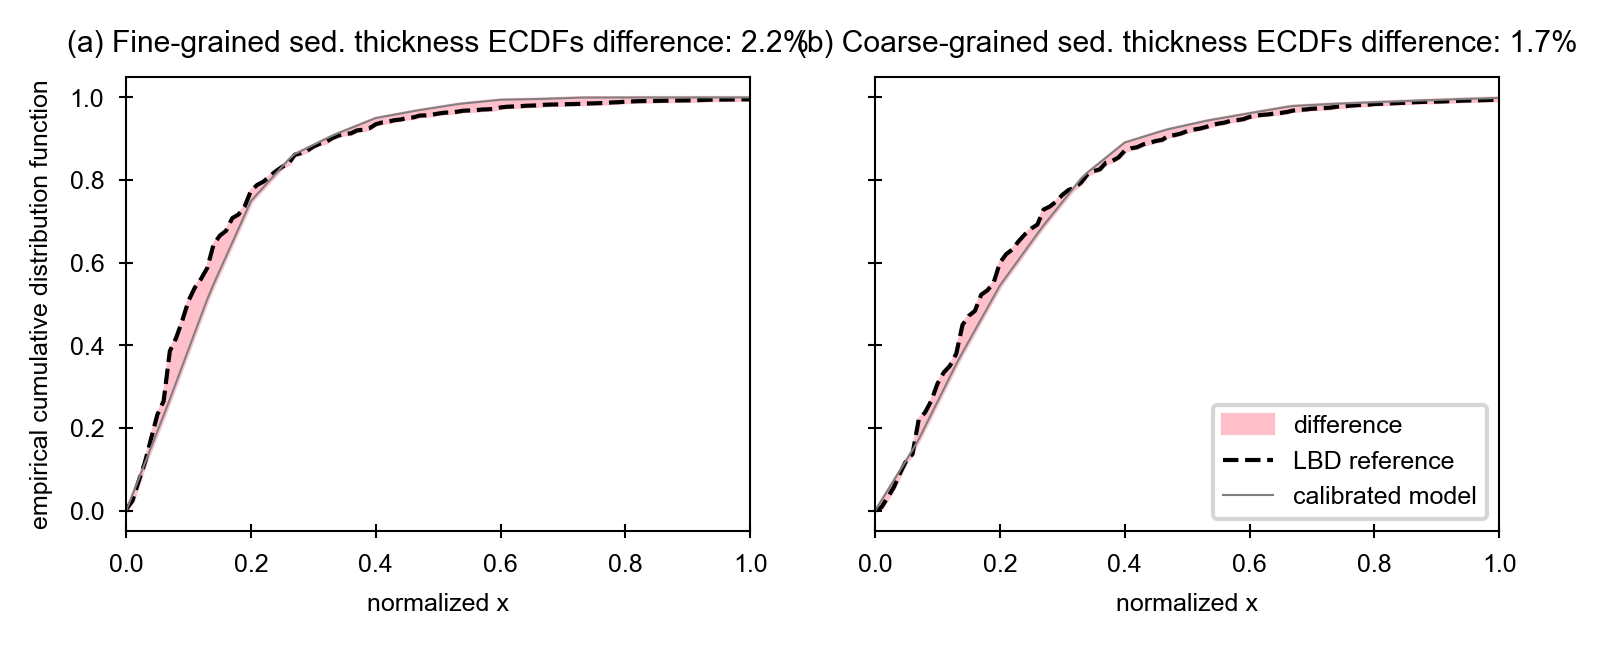

2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


In [7]:
for i in range (nseeds):
    print(str(i+1)+'/'+str(nseeds))
    # GENERATE TRUNCATED ELLIPSOID PARAMS FOR SAND LENSES AND CLAY LENSES
    #printtimelog('generate lense params')
    lenseClassesList = [sandLenses,clayLenses]
    Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies = gen_concatenated_lenses_params(lenseClassesList,mask_aquifer,dx,dz,lbdseed+3+i)
    
    # GENERATE OBJECT BASED MODELS
    #printtimelog('generate object based model')
    facies_mx,relative_youth_mx = gen_facies_youth_mx(aoi_vx,aoi_vy,aoi_vz,Lix,Liy,Liz,Ldipdir,Ldip,La,Lb,Lc,Ltruncr,Lfacies,mask_aquifer)
    
    # ADD DISTINCTION BETWEEN BASEMENT AND WEATHERED BASEMENT
    #printtimelog('differentiate basement from weathered basement')
    tmp_twt = np.tile(np.reshape(aoi_top_basement,(1,aoi_ny,aoi_nx)),(aoi_nz,1,1))
    ix_bst = np.where(zzz<tmp_twt)
    facies_mx[ix_bst]=-1

    # COMPUTE COUNT AND PROPORTIONS PER LITHOCODE
    #printtimelog('compute proportions')
    prop = get_facies_prop(facies_mx,mask_aquifer,lithocodes[2:],labels[2:])
    #print(prop)
    
    # GET THICKNESSES
    #printtimelog('extract thicknesses')
    df_model_thickness = get_model_litho_thickness(facies_mx,ndhsamples,aoi_nx,aoi_ny,lithocodes,zmin,dz,rng)
    
    # COMPUTE EMPIRICAL CUMULATIVE DISTRIBUTION FUNCTIONS OF THICKNESS PER LITHOCODE
    #printtimelogwithstarline('COMPUTE ECDFs')
    x_clay, ecdf_clay = get_ecdf(df_model_thickness,3)
    x_sand, ecdf_sand = get_ecdf(df_model_thickness,2)
    x_inte, ecdf_inte = get_ecdf(df_model_thickness,1)
    
    #printtimelog('normalize ecdfs')
    
    ecdf01_clay = interp_ecdf_normalize_x(x_clay,ecdf_clay,xlim,x01_vec)
    ecdf01_sand = interp_ecdf_normalize_x(x_sand,ecdf_sand,xlim,x01_vec)
    ecdf01_inte = interp_ecdf_normalize_x(x_inte,ecdf_inte,xlim,x01_vec)
    
    #printtimelogwithstarline('COMPUTE DISTANCE TO LBD DATASET')
    #printtimelog('compute errors')
    err_prop_clay = (float(prop.loc[3,'proportion'])/100-prop_clay_mean_p5_p95[0]) # / prop_clay_err_mean_p5_p95[0]
    err_prop_sand = (float(prop.loc[2,'proportion'])/100-prop_sand_mean_p5_p95[0]) #/ prop_sand_err_mean_p5_p95[0]
    
    
    err_ecdf_clay,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_clay_mean_p5_p95[:,0],x01_vec,ecdf01_clay,nbins=nbins,plot=False) #/ ecdf_clay_area_err_mean_p5_p95[0]
    err_ecdf_sand,_,_,_,_,_,_ = get_ecdf_area_difference(x01_vec,ecdf_sand_mean_p5_p95[:,0],x01_vec,ecdf01_sand,nbins=nbins,plot=False) #/ ecdf_sand_area_err_mean_p5_p95[0]
    # err_ratio_ecdf_inte,_,_,_,_,_, = get_ecdf_area_difference(x01_vec,ecdf_inte_mean_p5_p95[:,0],x01_vec,ecdf01_inte,nbins=nbins) #/ ecdf_inte_area_err_mean_p5_p95[0]
    
    #printtimelog('compute distance')
    errors = np.abs(np.array([err_prop_clay,err_prop_sand,err_ecdf_clay,err_ecdf_sand]))
    #print('errors: '+str(errors))
    
    similarity = np.prod(1-errors)**(1/len(errors))
    dist2lbd = 1 - similarity

    df_stats_errors.loc[i,"err_prop_clay"] = err_prop_clay
    df_stats_errors.loc[i,"err_prop_sand"] = err_prop_sand
    df_stats_errors.loc[i,"err_ecdf_clay"] = err_ecdf_clay
    df_stats_errors.loc[i,"err_ecdf_sand"] = err_ecdf_sand
    df_stats_errors.loc[i,"similarity"] = similarity
    df_stats_errors.loc[i,"dist2ref"] = dist2lbd

    if i==0:
        print('errors: '+str(errors))
        print('dist2lbd: '+str(dist2lbd))   
        print('np.mean(errors): '+str(np.mean(errors)))
        
        fgw = 15
        fts = 6
        
        ecdf_clay_ref = ecdf_clay_mean_p5_p95[:,0]
        ecdf_sand_ref = ecdf_sand_mean_p5_p95[:,0]
        plot_clay_and_sand_ecdfs_err(ecdf_clay_ref,ecdf_sand_ref,x01_vec,ecdf01_clay,ecdf01_sand,figsize=(fgw/2.54,fgw/15*5/2.54),fontsize=fts)


In [8]:
df_stats_errors.to_csv(output_fd+stats_fn,index=False)
df_stats_errors

,err_prop_clay,err_prop_sand,err_ecdf_clay,err_ecdf_sand,dist2ref,similarity
0,0.001398,-0.006084,0.021607,0.017116,0.011584,0.988416
1,0.015598,-0.011484,0.025482,0.013405,0.016507,0.983493
2,-0.033502,0.077516,0.030229,0.034426,0.044119,0.955881
3,-0.039902,0.006516,0.033435,0.011979,0.023059,0.976941
4,-0.006202,-0.062684,0.029761,0.032353,0.032959,0.967041
...,...,...,...,...,...,...
95,0.002098,-0.067284,0.027053,0.028264,0.031457,0.968543
96,-0.038302,0.000716,0.0353,0.014973,0.022443,0.977557
97,0.053298,-0.036484,0.022387,0.0173,0.032469,0.967531
98,0.029798,-0.019084,0.019985,0.009286,0.019565,0.980435


In [9]:
pct_confidence = 90
print(str(pct_confidence)+'% confidence, err_prop_clay <= '+str(np.percentile(np.abs(df_stats_errors["err_prop_clay"]),pct_confidence)))
print(str(pct_confidence)+'% confidence, err_prop_sand <= '+str(np.percentile(np.abs(df_stats_errors["err_prop_sand"]),pct_confidence)))
print(str(pct_confidence)+'% confidence, err_ecdf_clay <= '+str(np.percentile(df_stats_errors["err_ecdf_clay"],pct_confidence)))
print(str(pct_confidence)+'% confidence, err_ecdf_sand <= '+str(np.percentile(df_stats_errors["err_ecdf_sand"],pct_confidence)))
print(str(pct_confidence)+'% confidence, dist2ref <= '+str(np.percentile(df_stats_errors["dist2ref"],pct_confidence)))


90% confidence, err_prop_clay <= 0.0517377515082451
90% confidence, err_prop_sand <= 0.056163001674985155
90% confidence, err_ecdf_clay <= 0.0353293133159721
90% confidence, err_ecdf_sand <= 0.028799159446215472
90% confidence, dist2ref <= 0.035673283782558546


### Plot of errors - sensitivity to different stochastic realizations

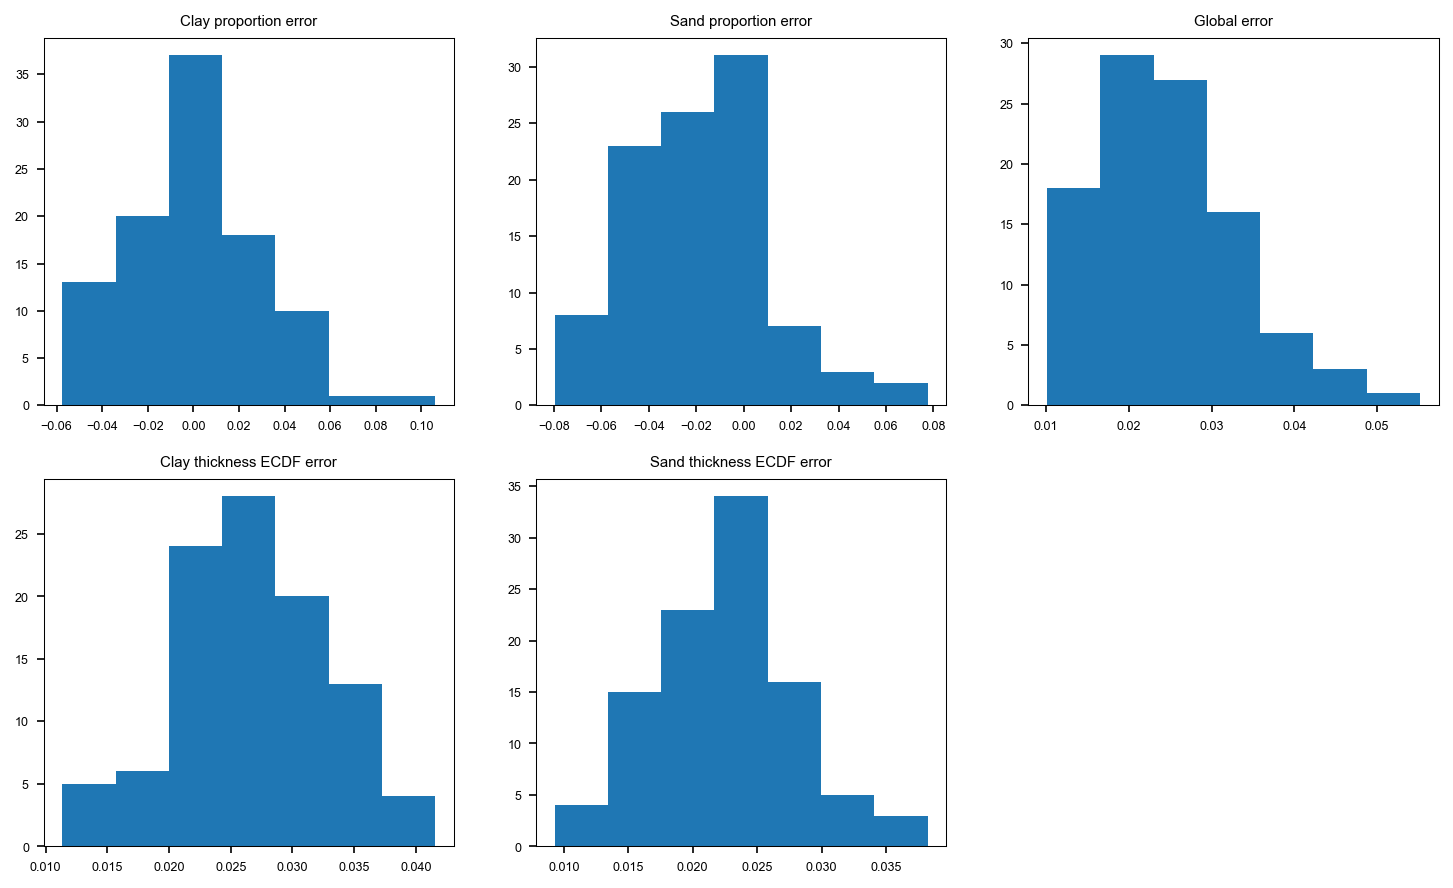

In [10]:
nbins = 7
plt.subplots(2,3,dpi=150,figsize=(12,7))
plt.subplot(2,3,1),plt.title('Clay proportion error')
plt.hist(df_stats_errors["err_prop_clay"],bins=nbins)

plt.subplot(2,3,2),plt.title('Sand proportion error')
plt.hist(df_stats_errors["err_prop_sand"],bins=nbins)

plt.subplot(2,3,3),plt.title('Global error')
plt.hist(df_stats_errors["dist2ref"],bins=nbins)

plt.subplot(2,3,4),plt.title('Clay thickness ECDF error')
plt.hist(df_stats_errors["err_ecdf_clay"],bins=nbins)

plt.subplot(2,3,5),plt.title('Sand thickness ECDF error')
plt.hist(df_stats_errors["err_ecdf_sand"],bins=nbins)

plt.subplot(2,3,6),plt.axis('off')
plt.show()

In [11]:
tmp = df_stats_errors["err_prop_clay"].values.astype('float')
tmp

array([ 0.00139775,  0.01559775, -0.03350225, -0.03990225, -0.00620225,
       -0.01420225, -0.01340225, -0.03470225,  0.10609775, -0.05750225,
       -0.02440225,  0.00949775, -0.01290225, -0.02800225,  0.05299775,
        0.04049775, -0.03810225, -0.02560225,  0.00449775,  0.05769775,
        0.00829775, -0.00140225, -0.01700225,  0.01989775,  0.05159775,
        0.01969775, -0.01030225,  0.02039775, -0.00550225,  0.01949775,
        0.00479775,  0.04919775,  0.02999775,  0.00229775, -0.01730225,
       -0.00830225, -0.04030225, -0.01120225, -0.03950225,  0.02279775,
       -0.01140225, -0.01980225,  0.00399775,  0.01659775,  0.05659775,
        0.06329775,  0.00419775,  0.05539775,  0.00299775, -0.01450225,
        0.00499775, -0.02500225, -0.00110225, -0.00300225, -0.01600225,
        0.00729775, -0.01410225,  0.03549775,  0.01959775,  0.00849775,
        0.03009775,  0.05589775,  0.00939775, -0.00790225, -0.00200225,
       -0.00470225,  0.00719775, -0.00310225, -0.02730225,  0.02

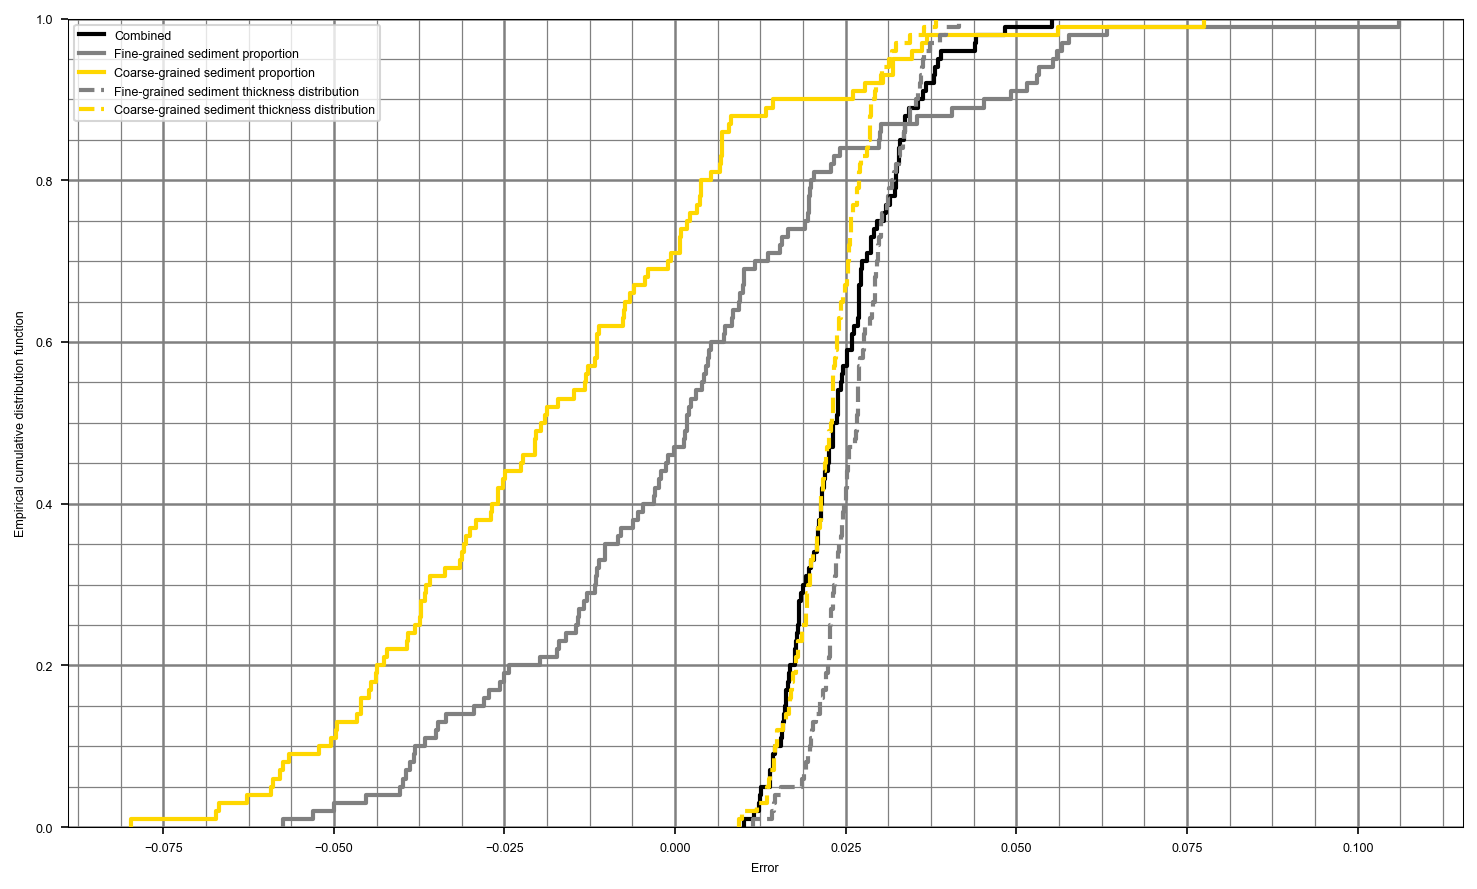

In [12]:
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(1,1,dpi=150,figsize=(12,7))
ax.ecdf((df_stats_errors["dist2ref"].values.astype('float')),lw=2,color='black',label = 'Combined')
ax.ecdf((df_stats_errors["err_prop_clay"].values.astype('float')),ls='-',lw=2, color='grey',label = 'Fine-grained sediment proportion')
ax.ecdf((df_stats_errors["err_prop_sand"].values.astype('float')),ls='-',lw=2, color='gold',label = 'Coarse-grained sediment proportion')

ax.ecdf((df_stats_errors["err_ecdf_clay"].values.astype('float')),ls='--',lw=2,color='grey',label = 'Fine-grained sediment thickness distribution')
ax.ecdf((df_stats_errors["err_ecdf_sand"].values.astype('float')),ls='--',lw=2,color='gold',label = 'Coarse-grained sediment thickness distribution')


ax.set_xlabel("Error")
ax.set_ylabel("Empirical cumulative distribution function")

ax.grid(True)
# Style the grid.
ax.grid(which='major', color='gray', linewidth=1.2)
ax.grid(which='minor', color='gray', linewidth=0.6)
# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which='minor', bottom=False, left=False)

# Only show minor gridlines once in between major gridlines.
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

plt.legend()
plt.show()